In [101]:
import sys
import os
from pathlib import Path
from typing import List, Tuple, Dict, Any, Union
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [149]:
src_pts.shape, dst_pts.shape, len(mask), mask.sum(), src_pts.dtype, dst_pts.dtype

((1073, 2), (1073, 2), 1073, 904, dtype('float32'), dtype('float32'))

In [136]:
src_pts.shape, dst_pts.shape

((1073, 2), (1073, 2))

(1132, 2) (1132, 2) 1132
mask.sum() 899


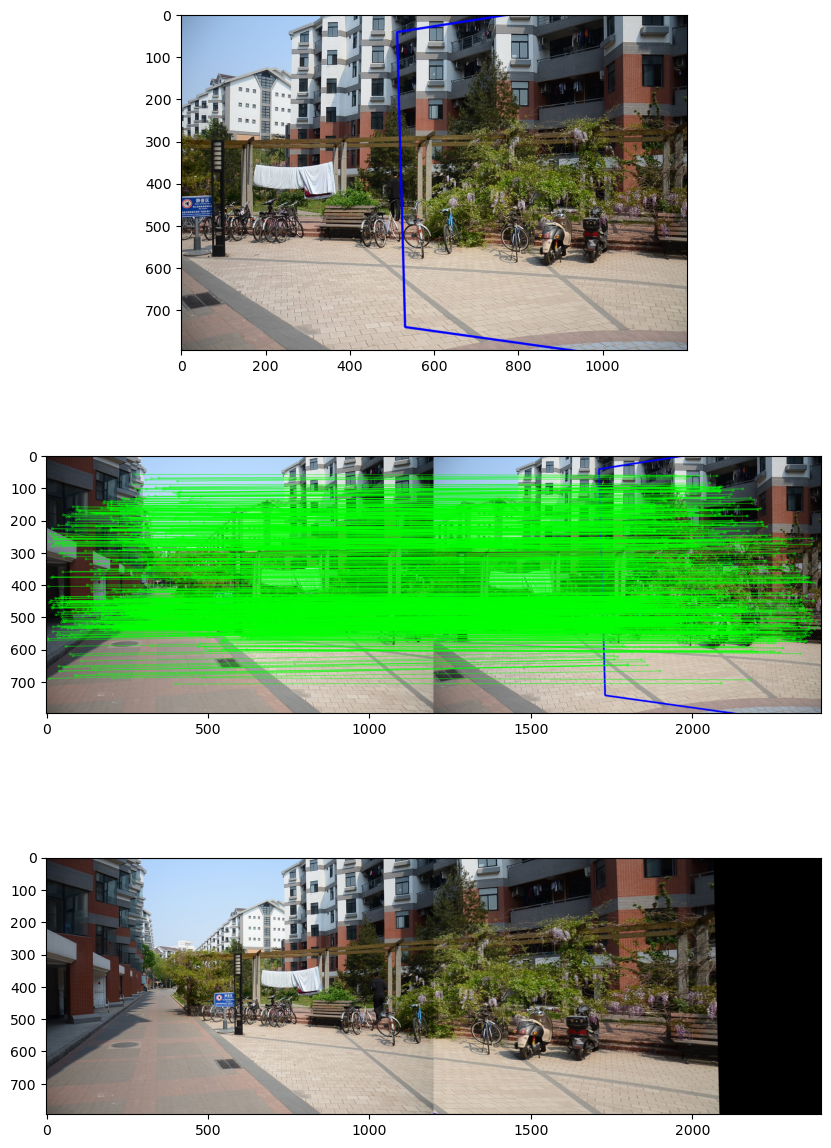

In [148]:
def _find_matches(img_left, img_right) -> Tuple[Tuple[cv2.KeyPoint], Tuple[cv2.KeyPoint], List[cv2.DMatch]]:
    # Open images and detect keypoints
    gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp_right, des_right = sift.detectAndCompute(gray, None) # len 3655, des1.shape 3655, 128
    gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    kp_left, des_left = sift.detectAndCompute(gray, None) # len 5618
    
    # match keypoints
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(des_right, des_left, k=2)

    # filter matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    return kp_left, kp_right, good_matches


def custom_ransac(src_pts: np.ndarray, dst_pts: np.ndarray, reproj_thresh: float) -> np.ndarray:
    """
    Parameters
    ----------
    src_pts : np.ndarray
        source points. shape (n,2). in this example n=1132
    dst_pts : np.ndarray
        destination points. shape (n,2). in this example n=1132
    reproj_thresh : float
        RANSAC reprojection error threshold

    Returns
    -------
    mask : np.ndarray
        mask indicating which matches are inliers. shape (n,1). in this example n=1132 and 899 values are 1 (ie used)
    """
    N = src_pts.shape[0]
    # run custom CUDA ransac code

    return np.ones((N, 1), dtype=np.uint8)
    
    
def _find_homography(kp1: List[cv2.KeyPoint], kp2: List[cv2.KeyPoint], good_matches: List[cv2.DMatch], ransac_method='opencv') -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters
    ----------
    kp1 : List[cv2.KeyPoint]
        keypoints from image 1
    kp2 : List[cv2.KeyPoint]
        keypoints from image 2
    good_matches : List[cv2.DMatch]
        list of good matches between keypoints from image 1 and image 2
    ransac_method : {'opencv', 'cuda'}
        method to use for RANSAC

    Returns
    -------
    M : np.ndarray
        3x3 homography matrix
    mask : np.ndarray
        mask indicating which matches are inliers
    """
    min_match_count = 10
    reproj_thresh = 4.0 # RANSAC reprojection error threshold

    if len(good_matches) <= min_match_count:
        raise Exception('Not enough matches are found - {}/{}'.format(len(good_matches), min_match_count))
    kp1_np = np.float32([x.pt for x in kp1])
    kp2_np = np.float32([x.pt for x in kp2])
    src_pts = np.float32([kp1_np[m.queryIdx] for m in good_matches])
    dst_pts = np.float32([kp2_np[m.trainIdx] for m in good_matches])
    if ransac_method == 'opencv':
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, reproj_thresh)
    elif ransac_method == 'cuda':
        mask = custom_ransac(src_pts, dst_pts)
        src_pts = src_pts[mask[:, 0] == 1]
        dst_pts = dst_pts[mask[:, 0] == 1]
        M, _ = cv2.findHomography(src_pts, dst_pts, 0, reproj_thresh) # without RANSAC
    else:
        raise ValueError('ransac_method must be one of {opencv, cuda}')
    return M, mask[:, 0]


def _plot(data_folder: str, subplot_idx: int, img: np.ndarray, mode: str, filename: str = None):
    if mode == 'plot':
        plt.subplot(subplot_idx)
        plt.imshow(img[:,:,::-1])
    elif mode == 'save':
        cv2.imwrite(data_folder + '/data/' + filename, img)


def main(data_folder: str | Path, mode: str = 'plot'):
    """
    Parameters
    ----------
    data_folder : str | Path
        Path to folder containing medium02 and medium03 images
    mode : {'plot', 'save', None}
        indicates if images should be displayed or saved in `data_folder`
        If saved name follows the format `output_{i}_*.png`
        if None does not save or plot images
    """

    if mode is not None:
        assert mode in ['plot', 'save']
        plt.figure(figsize=(10, 20))

    if isinstance(data_folder, Path):
        data_folder = str(data_folder)
    img_right = cv2.imread(data_folder + '/data/medium03.jpg')
    img_left = cv2.imread(data_folder + '/data/medium02.jpg')

    # Detect keypoints and find matches between keypoints
    kp_left, kp_right, good_matches = _find_matches(img_left, img_right)

    # find homography
    M, mask = _find_homography(kp_right, kp_left, good_matches, ransac_method='opencv')
    h, w, d = img_right.shape
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M).astype(np.int32)
    img_right = cv2.polylines(img_right, [dst], True, 255, 3, cv2.LINE_AA)
    _plot(data_folder, 411, img_right, mode, 'output_1_stitched.jpg')

    # draw matches
    draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=mask, flags=2)
    img3 = cv2.drawMatches(img_left, kp_right, img_right, kp_left, good_matches, None, **draw_params)
    _plot(data_folder, 412, img3, mode, 'output_2_matches.jpg')

    # stitch images
    dst = cv2.warpPerspective(img_right, M, (img_right.shape[1] + img_left.shape[1], img_right.shape[0]))
    dst[0:img_right.shape[0], 0:img_right.shape[1]] = img_left
    _plot(data_folder, 413, dst, mode, 'output_3_stitched.jpg')
    

main('./', mode='plot')